#### Covering the combinatorial design space of multiplex CRISPR/Cas experiments in plants
## Figure 1.2


Load packages

In [1]:
using Random 
using Plots  
using Distributions 
using LinearAlgebra
using Combinatorics
using BioCCP


(process:7232): GLib-GIO-WARNING **: 17:48:13.446: Unexpectedly, UWP app `HaukeGtze.7-ZipFileManagerUnofficial_1.2107.2.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.7-ZipFileManagerUnofficial_6bk20wvc8rfx2!zFM.exe') supports 36 extensions but has no verbs


Define functions for generating gRNA abundance distribution and gRNA genome editing efficiency distribution

In [2]:
function gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false)
    d_gRNAlibrary = truncated(Normal(m, sd), l, u)
    gRNA_abundances = collect(rand(d_gRNAlibrary, gRNA_total))
     if visualize
        return histogram(gRNA_abundances, label="", 
            xlabel="Number of reads per gene", 
            ylabel="absolute frequency", title="Read distribution")
    else
        if normalize
            gRNA_abundances /= sum(gRNA_abundances)
        end
        return gRNA_abundances
    end
end

gRNA_frequency_distribution (generic function with 1 method)

In [3]:
function gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, n_gRNAs; visualize=false)   
    d_activity = Binomial(1, p_high_activity)
    d_highactivity = truncated(Normal(μ_high_activity, σ_activity), 0.01, 1)
    d_lowactivity = truncated(Normal(μ_low_activity, σ_activity), 0.01, 1)
    p_gRNA_act = zeros(n_gRNAs) # initialize
    for i in 1:n_gRNAs
        if rand(d_activity, 1) == [1]
            p_gRNA_act[i] = rand(d_highactivity, 1)[1]
        else
            p_gRNA_act[i] = rand(d_lowactivity, 1)[1]
        end
    end
    if visualize
        return histogram(p_gRNA_act, label="", xlabel="gRNA activity", ylabel="absolute frequency", title="gRNA activity distribution")

    else
        return p_gRNA_act
    end
end

gRNA_activity_distribution (generic function with 1 method)

Define functions from simulation- and BioCCP-based framework

In [5]:
function simulate_Nₓ₂(n_targets, 
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global; iter=500)
    """ 
    INPUT
  
    
    OUTPUT
    E: expected minimum number of plants to gRNA_read_distributionsee each pairwise combination at least once
    sd: standard deviation on the minimum number of plants
    """
    @assert n_targets * n_gRNA_pergene == n_gRNA_total
#     @assert sum(p_gRNA_library) == 1
    
    T_vec = [] #stores number of plants required for each experiment
        for i in 1:iter     
            if i % 100 == 0
                println("Iteration: $i ... Calculating minimum number of plants ... \n")
            end   
            X_interactions_count = zeros(n_targets, n_targets) # Initialize matrix to count pairwise interactions
            T = 0
            while X_interactions_count != ones(n_targets, n_targets) # check if all pairwise combinations are present
                T += 1 # count how many plants must be sampled to fill pairwise interaction matrix
                
                # sample combinatorial gRNA/Cas9 construct
                gRNA_indices_construct = findall((rand(Multinomial(n_gRNA_perconstruct, p_gRNA_library))) .!= 0)
                
                # execute mutations
                gRNA_indices_mutations = [gRNA for gRNA in gRNA_indices_construct if rand(Binomial(1, p_gRNA_act[gRNA])) == 1]
            
                # effective gene knockout (loss-of-function) ?
                gRNA_indices_KO = [gRNA for gRNA in gRNA_indices_mutations if rand(Binomial(1, ϵ_knockout_global)) == 1]
            
                # which genes are knocked out?
                genes_indices_KO = Int.(ceil.(gRNA_indices_KO / n_gRNA_pergene))
            
                # which pairwise combinations are present?
                interactions = collect(combinations(genes_indices_KO, 2))
                
                # Store represented combinations in matrix
                for interaction in interactions
                    j = interaction[1]; k = interaction[2]
                    X_interactions_count[j,k] = 1; X_interactions_count[k,j] = 1; X_interactions_count[j,j] = 1; X_interactions_count[k,k] = 1          
                end  
            end
            push!(T_vec, T)   
              
        end
        E = mean(T_vec); sd = std(T_vec)
    return E, sd
end



BioCCP_Nₓ₂ (generic function with 1 method)

In [ ]:
function BioCCP_Nₓ₂(n_targets, 
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global)
    
    # how many pairwise combinations of gRNAs
    ind_combinations_gRNA = collect(combinations(1:n_gRNA_total, 2))
    n_combinations_gRNA = length(ind_combinations_gRNA)
    
    # calculate probability and activity of gRNA combinations
    p_combinations_gRNA_library = zeros(n_combinations_gRNA)
    p_combinations_gRNA_act = zeros(n_combinations_gRNA)
    for i in 1:n_combinations_gRNA
        p_combinations_gRNA_library[i] = p_gRNA_library[ind_combinations_gRNA[i][1]] * p_gRNA_library[ind_combinations_gRNA[i][2]]
        p_combinations_gRNA_act[i] = p_gRNA_act[ind_combinations_gRNA[i][1]] * p_gRNA_act[ind_combinations_gRNA[i][2]]
    end
    
    # normalize probability gRNA combinations
    p_combinations_gRNA_library /= sum(p_combinations_gRNA_library)

    # select pairwise gRNA combinations of which each component codes for different gene (goal is to study combinations of knockouts in different genes)
    p_combinations_gRNA_library_interest = []
    p_combinations_gRNA_act_interest = []
    ind_combinations_gRNA_interest = []
    for i in 1:n_combinations_gRNA
        if ceil(ind_combinations_gRNA[i][1]/n_gRNA_pergene) != ceil(ind_combinations_gRNA[i][2]/n_gRNA_pergene)
            push!(p_combinations_gRNA_library_interest, p_combinations_gRNA_library[i])
            push!(p_combinations_gRNA_act_interest, p_combinations_gRNA_act[i])
            push!(ind_combinations_gRNA_interest, ind_combinations_gRNA[i])
        end
    end
        
    n_combinations_gRNA_interest = length(p_combinations_gRNA_library_interest)
    p_combinations_gRNA = p_combinations_gRNA_library_interest .* p_combinations_gRNA_act_interest * ϵ_knockout_global^2

    #### INTEGREREN PER GENCOMBINATIE
    p_genes_matrix = zeros(n_targets, n_targets)
    for i in 1:n_combinations_gRNA_interest
        gene1 = Int(ceil(ind_combinations_gRNA_interest[i][1]/n_gRNA_pergene))
        gene2 = Int(ceil(ind_combinations_gRNA_interest[i][2]/n_gRNA_pergene))
        p_genes_matrix[gene1, gene2] += p_combinations_gRNA[i]
    end
    p_genes = collect([p_genes_matrix[i, j] for j in 2:size(p_genes_matrix, 1) for i in 1:j-1])  
    n_combinations_genes = length(p_genes)
    combinations_pp = length(collect(combinations(1:n_gRNA_perconstruct, 2)))
    
    return expectation_minsamplesize(n_combinations_genes; p=p_genes, r=combinations_pp, normalize=false), std_minsamplesize(n_combinations_genes; p=p_genes, r=combinations_pp, normalize=false)
end

#### Generate Figure

- Parameter values

In [21]:
targets = 20
gRNA_pergene = 6
gRNA_total = targets * gRNA_pergene
gRNA_perconstruct = 2
Random.seed!(1)
p_high_activity = 0.9
μ_high_activity = 0.9
μ_low_activity = 0.1
σ_activity = 0.01
d_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false); 
ϵ = 0.8

ρ  = 2
l = 50
u = 50*ρ 
m= (l+u)/2
sd = (u-l)/2
Random.seed!(1)
d = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = false, visualize=false);

- Figure 1A: Influence of number of target genes (N) on the plant library size for full combinatorial coverage

In [22]:
### N = 10
n_targets = 10
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_10_sim, sd_10_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_10_bioccp, sd_10_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 20
n_targets = 20
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_20_sim, sd_20_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_20_bioccp, sd_20_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 30
n_targets = 30
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_30_sim, sd_30_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_30_bioccp, sd_30_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 40
n_targets = 40
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(80)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_40_sim, sd_40_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_40_bioccp, sd_40_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 50
n_targets = 50
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_50_sim, sd_50_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_50_bioccp, sd_50_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteratio

(24397, 4627)

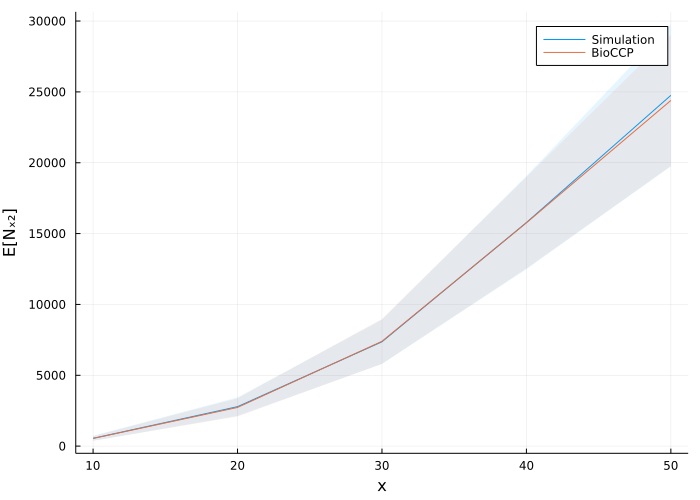

In [24]:
E_targets_sim = [E_10_sim, E_20_sim, E_30_sim, E_40_sim, E_50_sim]
E_targets_bioccp = [E_10_bioccp, E_20_bioccp, E_30_bioccp, E_40_bioccp, E_50_bioccp]
sd_targets_sim = [sd_10_sim, sd_20_sim, sd_30_sim, sd_40_sim, sd_50_sim]
sd_targets_bioccp = [sd_10_bioccp, sd_20_bioccp, sd_30_bioccp, sd_40_bioccp, sd_50_bioccp];

plot(collect(10:10:50), E_targets_sim, label="Simulation", 
    title="", xlabel="x", ylabel="E[Nₓ₂]",
    ribbon = sd_targets_sim, fillalpha=.1,
    xticks = (10:10:50, string.(10:10:50)),
    yticks = (0:5000:50000, string.(0:5000:50000)),
size = ((700,500)),
titlefont=font(11),
guidefontsize =11, guidefontfamily=101)

plot!(collect(10:10:50), E_targets_bioccp,  label="BioCCP",
    ribbon = sd_targets_bioccp, 
    fillalpha=.1,
)

- Figure 1B: Influence of number of global knockout efficiency on the plant library size for full combinatorial coverage

In [ ]:
n_targets = 20
n_gRNA_pergene = 6
n_gRNA_total= n_targets * n_gRNA_pergene
n_gRNA_perconstruct = 2

ρ = 2
l = 50
u = ρ*l 
m= (l+u)/2
sd= (u-l)/2
Random.seed!(1)
p_gRNA_lib = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_activity = 0.01
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_activity, n_gRNA_total; visualize=false) ;

## 70
ϵ_knockout_global = 0.7

E_p_KO70_bioccp, sd_p_KO70_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO70_sim, sd_p_KO70_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

## 80
ϵ_knockout_global = 0.8

E_p_KO80_bioccp, sd_p_KO80_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO80_sim, sd_p_KO80_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

## 90
ϵ_knockout_global = 0.9

E_p_KO90_bioccp, sd_p_KO90_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO90_sim, sd_p_KO90_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)
## 100
ϵ_knockout_global = 1

E_p_KO100_bioccp, sd_p_KO100_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO100_sim, sd_p_KO100_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

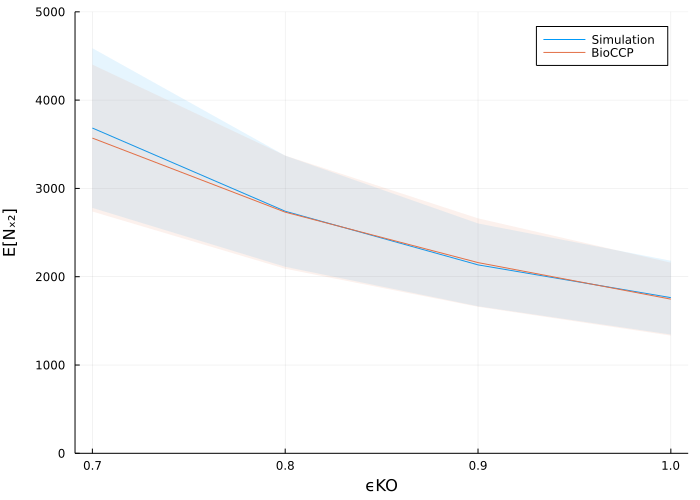

In [26]:
E_p_KO_sim = [E_p_KO70_sim, E_p_KO80_sim, E_p_KO90_sim,E_p_KO100_sim]
E_p_KO_bioccp = [E_p_KO70_bioccp, E_p_KO80_bioccp, E_p_KO90_bioccp, E_p_KO100_bioccp]
sd_p_KO_sim = [sd_p_KO70_sim, sd_p_KO80_sim, sd_p_KO90_sim,sd_p_KO100_sim]
sd_p_KO_bioccp = [sd_p_KO70_bioccp, sd_p_KO80_bioccp, sd_p_KO90_bioccp, sd_p_KO100_bioccp];

plot([0.7, 0.8, 0.9, 1], E_p_KO_sim, label="Simulation", 
    title="", xlabel="ϵKO", ylabel="E[Nₓ₂]",
    ribbon = sd_p_KO_sim, fillalpha=.1,
    xticks = ([0.7, 0.8, 0.9, 1], string.([0.7, 0.8, 0.9, 1])),
    yticks = (0:1000:11000, string.(0:1000:11000)),
    ylim=(0,5000),
size = ((700,500)),
titlefont=font(11),
guidefontsize =11, guidefontfamily=101)

plot!([0.7, 0.8, 0.9, 1], E_p_KO_bioccp,  label="BioCCP",
    ribbon = sd_p_KO_bioccp, 
    fillalpha=.1,
)

- Figure 1C: Influence of number of width of rho on the plant library size for full combinatorial coverage

In [19]:
# reset some parameters to default
targets = 20
gRNA_pergene = 6
gRNA_total = gRNA_pergene * targets

120

In [7]:
iter = 15

Es_p1_bioccp = zeros(iter, 6)
sds_p1_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d_1 = ones(gRNA_total)/gRNA_total
    d_act = ones(gRNA_total)
    E, sd = BioCCP_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d_1, 
                              d_act, ϵ)
    Es_p1_bioccp[i,gRNA_pergene] = E
    sds_p1_bioccp[i,gRNA_pergene] = sd

    end
end

##2
ρ  = 2
l = 50
u = 50*ρ 
m= (l+u)/2
sd = (u-l)/2


### vary number of gRNAs per gene
Es_p2_bioccp = zeros(iter, 6)
sds_p2_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d_2 = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false)
    d_act = ones(gRNA_total)
    E, sd = BioCCP_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d_2, 
                              d_act, ϵ)
    Es_p2_bioccp[i,gRNA_pergene] = E
    sds_p2_bioccp[i,gRNA_pergene] = sd
    end
end

##4
ρ = 4
l = 50
u = 50 * ρ 
m= (l+u)/2
sd = (u-l)/2


### vary number of gRNAs per gene
Es_p4_bioccp = zeros(iter, 6)
sds_p4_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d_4 = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false)
    d_act = ones(gRNA_total)
    E, sd = BioCCP_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d_4, 
                              d_act, ϵ)
    Es_p4_bioccp[i,gRNA_pergene] = E
    sds_p4_bioccp[i,gRNA_pergene] = sd
    end
end

##8
ρ  = 8
l = 50
u = 50 * ρ 
m= (l+u)/2
sd = (u-l)/2


### vary number of gRNAs per gene
Es_p8_bioccp = zeros(iter, 6)
sds_p8_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
        ρ  = 8
l = 50
u = 50 * ρ 
m= (l+u)/2
sd = (u-l)/2

    d_8 = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false)
    d_act = ones(gRNA_total)
    E, sd = BioCCP_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d_8, 
                              d_act, ϵ)
    Es_p8_bioccp[i,gRNA_pergene] = E
    sds_p8_bioccp[i,gRNA_pergene] = sd
    end
end

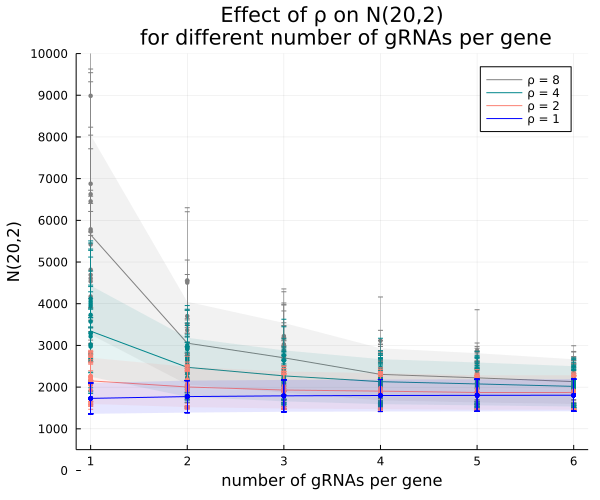

In [14]:
markersize = 2.5
markerstrokewidth=0.4

scatter(1:6, Es_p8_bioccp', errorbar=sds_p8_bioccp', color=:grey, label="",markersize=markersize, 
    markerstrokewidth=markerstrokewidth, markerstrokecolor=:grey)
plot!(1:6, mean(Es_p8_bioccp, dims=1)[:], color=:grey, ribbon=mean(sds_p8_bioccp, dims=1)[:],fillalpha=.1,
size = ((850,600)),label="ρ = 8", ylim=(500,10000),
xlabel="number of gRNAs per gene", ylabel="N(20,2)", title="Effect of ρ on N(20,2)
    for different number of gRNAs per gene")


scatter!(1:6, Es_p4_bioccp', errorbar=sds_p4_bioccp', color=:turquoise4, label="",
    markersize=markersize, markerstrokewidth=markerstrokewidth,  markerstrokecolor=:turquoise4)
plot!(1:6, mean(Es_p4_bioccp, dims=1)[:], color=:turquoise4, ribbon=mean(sds_p4_bioccp, dims=1)[:],  fillalpha=.1,
     yticks = (0:1000:10000, string.(0:1000:10000)),label="ρ = 4")

scatter!(1:6, Es_p2_bioccp', errorbar=sds_p2_bioccp', color=:salmon, label="",
    markersize=markersize, markerstrokewidth=markerstrokewidth,  markerstrokecolor=:salmon)
plot!(1:6, mean(Es_p2_bioccp, dims=1)[:], color=:salmon, ribbon=mean(sds_p2_bioccp, dims=1)[:],  fillalpha=.1, label="ρ = 2")

scatter!(1:6, Es_p1_bioccp', errorbar=sds_p1_bioccp', color=:blue, label="", 
    markersize=markersize, markerstrokewidth=markerstrokewidth,  markerstrokecolor=:blue ) #, markeralpha=0)
plot!(1:6, mean(Es_p1_bioccp, dims=1)[:], color=:blue, ribbon=mean(sds_p1_bioccp, dims=1)[:],  fillalpha=.1,
size = ((600,500)),label="ρ = 1")


- Figure 1D: Influence of fraction of all gRNAs that is active on the plant library size for full combinatorial coverage

In [16]:
iter = 15

# f7
### vary number of gRNAs per gene
Es_f7_bioccp = zeros(iter, 6)
sds_f7_bioccp = zeros(iter, 6) 

for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d = ones(gRNA_total)/gRNA_total
    p_high_activity = 0.7
    μ_high_activity = 0.9;     μ_low_activity = 0.1; σ_activity = 0.01
    d_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false);  

    E, sd = BioCCP_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d, 
                              d_act, ϵ)
    Es_f7_bioccp[i,gRNA_pergene] = E
    sds_f7_bioccp[i,gRNA_pergene] = sd
    end
end

## f8
### vary number of gRNAs per gene
Es_f8_bioccp = zeros(iter, 6)
sds_f8_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d = ones(gRNA_total)/gRNA_total
    p_high_activity = 0.8
    μ_high_activity = 0.9;     μ_low_activity = 0.1;     σ_activity = 0.01
    d_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false);  
    E, sd = BioCCP_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d, 
                              d_act, ϵ)
    Es_f8_bioccp[i,gRNA_pergene] = E
    sds_f8_bioccp[i,gRNA_pergene] = sd
    end
end

##f9 
### vary number of gRNAs per gene
Es_f9_bioccp = zeros(iter, 6)
sds_f9_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d = ones(gRNA_total)/gRNA_total
    p_high_activity = 0.9
    μ_high_activity = 0.9
    μ_low_activity = 0.1
    σ_activity = 0.01
    d_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false);  

    E, sd = BioCCP_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d, 
                              d_act, ϵ)
    Es_f9_bioccp[i,gRNA_pergene] = E
    sds_f9_bioccp[i,gRNA_pergene] = sd
    end
end


##f1
 
### vary number of gRNAs per gene
Es_f1_bioccp = zeros(iter, 6)
sds_f1_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d = ones(gRNA_total)/gRNA_total
    p_high_activity = 1
    μ_high_activity = 0.9
    μ_low_activity = 0.1
    σ_activity = 0.01
    d_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false);  

    E, sd = BioCCP_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d, 
                              d_act, ϵ)
    Es_f1_bioccp[i,gRNA_pergene] = E
    sds_f1_bioccp[i,gRNA_pergene] = sd
    end
end

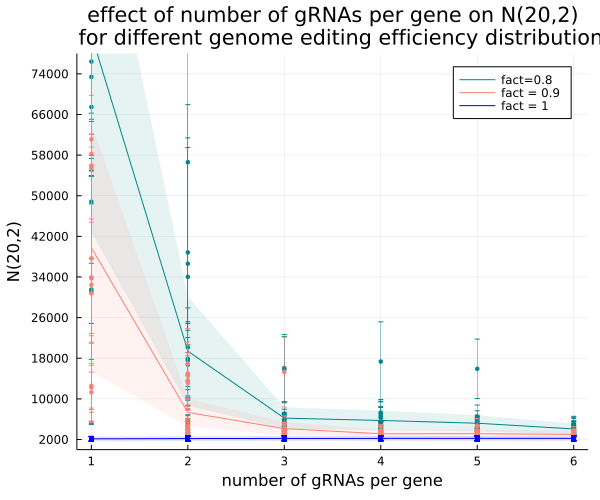

In [17]:
markersize = 2.5
markerstrokewidth=0.4

scatter(1:6, Es_f8_bioccp', errorbar=sds_f8_bioccp', color=:turquoise4, label="",
    markersize=markersize, markerstrokewidth=markerstrokewidth,  markerstrokecolor=:turquoise4)
plot!(1:6, mean(Es_f8_bioccp, dims=1)[:], color=:turquoise4, ribbon=mean(sds_f8_bioccp, dims=1)[:],  fillalpha=.1,
     yticks = (2000:8000:78000, string.(2000:8000:78000)),
    label="fact=0.8",
        ylim=(0,78000),
xlabel="number of gRNAs per gene", ylabel="N(20,2)", title="effect of number of gRNAs per gene on N(20,2)
    for different genome editing efficiency distributions")

scatter!(1:6, Es_f9_bioccp', errorbar=sds_f9_bioccp', color=:salmon, label="", 
    markersize=markersize, markerstrokewidth=markerstrokewidth,  markerstrokecolor=:salmon)
plot!(1:6, mean(Es_f9_bioccp, dims=1)[:], color=:salmon, ribbon=mean(sds_f9_bioccp, dims=1)[:],  fillalpha=.1, label="fact = 0.9")

scatter!(1:6, Es_f1_bioccp', errorbar=sds_f1_bioccp', color=:blue, label="", 
    markersize=markersize, markerstrokewidth=markerstrokewidth,  markerstrokecolor=:blue ) #, markeralpha=0)
plot!(1:6, mean(Es_f1_bioccp, dims=1)[:], color=:blue, ribbon=mean(sds_f1_bioccp, dims=1)[:],  fillalpha=.1,
size = ((600,500)),label="fact = 1")